## Модуль Б.  Разведочный анализ данных

#### Импортирование библиотек

In [1]:
import pandas as pd
import io
import glob
import re
import nltk
import matplotlib.pyplot as plt
import pymorphy2
import fitz
import string
import numpy as np
import re
import pyLDAvis
import pyLDAvis.gensim
from nltk.stem import *
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm, trange
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn
from __future__ import division
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
import seaborn as sns

### 1.2 Формирование структуры набора данных

### Описание структуры данных

__TitleCompany__ - Название компании

__TextPostLemat__ - обработанный, лематизированный текст 

__TextPostToken__ - обработанный, токенизированный и лематизированный текст (лематизирован другим способом нежели TextPostLemat)

__bigram__ - биграммы обработанного и лематизированного текста

__trigram__ - триграммы обработанного и лематизированного текста

__keyword__ - ключевые слова обработанного и лематизированного текста

__clustersAgglomerative__ - кластеры, образованные моделью Agglomerative

__clustersKmeans__ - кластеры, образованные моделью Kmeans

__clustersSpectral__ - кластеры, образованные моделью Spectral

#### Установка библиотек

### 2.1 Поиск ключевых слов/n-грамм. Векторизация текстов

In [2]:
dfHabr1 = pd.read_csv(r'Report1.csv')

In [3]:
mystem = Mystem() 
# добавление стопслов
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['…', '«', '»', '...', 'быть', 'r', 'n', 'а', 'мы', 'с', 'для', 'ещё', 'его', 'также', 'к', 'тем', 'кто', 'чтобы', 'но', 'они', 'будут', 'так', 'где', 'один', 'он ', 'и', 'на', 'но', 'или', 'либо', 'это', 'мб', 'далее', 'дв', 'свой', 'ваш','всё', 'очень', 'её', 'ещё', 'вообще', 'наш', 'который'])

Из-за проблем с чтением нужно заново токенизировать текст, именно поэтому заново прописываю метод токенизации на лемматизированном тексте

In [4]:
dfHabr1.head()

,TitleCompany,TextPost,TextPostLemat,TextPostToken
0,Нетология,Многие из нас ежедневно пользуются поисковыми...,многие ежедневно пользоваться поисковый систем...,многие нас ежедневно пользуются поисковыми сис...
1,Gett,"Всем привет, меня зовут Антон Тупиков, я – ти...",привет звать антон тупик тимлид команда просто...,всем привет меня зовут антон тупиков тимлид ко...
2,Gett,"Привет! Меня зовут Виталий Костоусов, я работ...",привет звать виталий костоусов работать команд...,привет меня зовут виталий костоусов работаю ко...
3,Gett,"Всем привет, меня зовут Лера Лисичкина, я рук...",привет звать лера лисичкин руководить технолог...,всем привет меня зовут лера лисичкина руковожу...
4,Gett,"Всем привет, меня зовут Антон Тупиков, я – ти...",привет звать антон тупик тимлид команда просто...,всем привет меня зовут антон тупиков тимлид ко...


In [5]:
def tokenize(text):
    t = word_tokenize(text)
    return [token for token in t if token not in russian_stopwords]

In [6]:
morph = pymorphy2.MorphAnalyzer()

C:\Users\essww\anaconda3\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\essww\anaconda3\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\essww\anaconda3\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\essww\anaconda3\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, def

In [7]:
# обработка текста токенизацией
prep_text1 = [tokenize(text.lower()) for text in tqdm(dfHabr1['TextPostLemat']) if text not in russian_stopwords]

  0%|          | 0/38 [00:00<?, ?it/s]

In [8]:
dfHabr1['TextPostToken'] = prep_text1

In [9]:
dfHabr1['bigram'] = ''
dfHabr1['trigram'] = ''
dfHabr1['keyword'] = ''

#### Создание биграммы, триграммы и ключевых слов, а также добавления их в датафрейм

In [10]:
# использование цикла с записью биграмм в датафрейм
for i in tqdm(range(len(dfHabr1['TextPostToken']))):
    dfHabr1['bigram'][i] = list(nltk.ngrams(dfHabr1['TextPostToken'][i], 2))
# использование цикла с записью триграмм в датафрейм
for i in tqdm(range(len(dfHabr1['TextPostToken']))):
    dfHabr1['trigram'][i] = list(nltk.ngrams(dfHabr1['TextPostToken'][i], 3))
# использование цикла с записью ключевых слов в датафрейм
for i in tqdm(range(len(dfHabr1['TextPostToken']))):
    freq_dist = nltk.FreqDist(dfHabr1['TextPostToken'][i])
    top_words = [word for word, count in freq_dist.most_common(10)]
    dfHabr1['keyword'][i] = ', '.join(top_words)

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

In [11]:
dfHabr1.head()

,TitleCompany,TextPost,TextPostLemat,TextPostToken,bigram,trigram,keyword
0,Нетология,Многие из нас ежедневно пользуются поисковыми...,многие ежедневно пользоваться поисковый систем...,"[многие, ежедневно, пользоваться, поисковый, с...","[(многие, ежедневно), (ежедневно, пользоваться...","[(многие, ежедневно, пользоваться), (ежедневно...","человек, язык, компьютерный, текст, лингвистик..."
1,Gett,"Всем привет, меня зовут Антон Тупиков, я – ти...",привет звать антон тупик тимлид команда просто...,"[привет, звать, антон, тупик, тимлид, команда,...","[(привет, звать), (звать, антон), (антон, тупи...","[(привет, звать, антон), (звать, антон, тупик)...","сервис, год, поездка, решение, клиент, каждый,..."
2,Gett,"Привет! Меня зовут Виталий Костоусов, я работ...",привет звать виталий костоусов работать команд...,"[привет, звать, виталий, костоусов, работать, ...","[(привет, звать), (звать, виталий), (виталий, ...","[(привет, звать, виталий), (звать, виталий, ко...","проблема, сервис, работать, работа, команда, м..."
3,Gett,"Всем привет, меня зовут Лера Лисичкина, я рук...",привет звать лера лисичкин руководить технолог...,"[привет, звать, лера, лисичкин, руководить, те...","[(привет, звать), (звать, лера), (лера, лисичк...","[(привет, звать, лера), (звать, лера, лисичкин...","команда, рассказывать, разработка, начинать, р..."
4,Gett,"Всем привет, меня зовут Антон Тупиков, я – ти...",привет звать антон тупик тимлид команда просто...,"[привет, звать, антон, тупик, тимлид, команда,...","[(привет, звать), (звать, антон), (антон, тупи...","[(привет, звать, антон), (звать, антон, тупик)...","сервис, год, поездка, решение, клиент, каждый,..."


In [12]:
# метод препроцессинга, необходимый для полной очистки всего ненужного
def preprocess_text(data, stopwords=russian_stopwords):
    text = re.sub('ё','е', data.lower())
    text = text.strip()
    text = [w for w in text.split() if w not in stopwords] 
    text = [w for w in text if len(w) >=3]
    return ' '.join(text)

In [13]:
# вызов препроцессинга и трансформация
def transform_data(data: pd.Series) -> list:
    result = [preprocess_text(data=i) for i in data]
    return result

In [14]:
text = dfHabr1['TextPostLemat']

In [15]:
%%time
dfHabr2 = transform_data(text)

CPU times: total: 15.6 ms
Wall time: 44.6 ms


In [16]:
len(dfHabr2)

38

#### Векторизация текста, для дальнейшей обработки

In [17]:
vectorizer = CountVectorizer(analyzer='word', stop_words=russian_stopwords, ngram_range=(1, 3), min_df=1)
count_matrix = vectorizer.fit_transform(dfHabr2)

In [18]:
count_matrix.toarray()[:2,:200]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 7, 1, 1, 0, 0, 1, 1, 3, 3, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2,
        0, 0, 1, 1, 1, 1, 5, 0, 0, 5, 1, 1, 1, 1, 1, 3, 1, 1, 0, 0, 1, 1,
        1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 

In [19]:
count_matrix.shape

(38, 41972)

In [20]:
vectorizer.get_feature_names_out()[:50]

array(['абасмирзоев', 'абасмирзоев глава', 'абасмирзоев глава домен',
       'абитуриент', 'абитуриент год', 'абитуриент год нетология',
       'аброськин', 'аброськин сбермаркет',
       'аброськин сбермаркет панацеяантон', 'абсолютно',
       'абсолютно лишний', 'абсолютно лишний никита', 'абстрактный',
       'абстрактный трактование', 'абстрактный трактование пример',
       'абстракция', 'абстракция интерфейс',
       'абстракция интерфейс слушатель', 'авангард',
       'авангард российский', 'авангард российский бизнес', 'авангардный',
       'авангардный решение', 'авангардный решение массовый', 'август',
       'август год', 'август год профессиональный', 'авиа',
       'авиа автобусный', 'авиа автобусный билет', 'авиабилет',
       'авиабилет часто', 'авиабилет часто покупать', 'авиакомпания',
       'авиакомпания мир', 'авиакомпания мир вместе', 'авито',
       'авито конфета', 'авито конфета меч', 'авито присоединяться',
       'авито присоединяться владислав', 'авитовец', '

In [21]:
len(vectorizer.get_feature_names_out())

41972

### 2.3 Кластеризация

Agglomerative - это метод кластеризации, который относится к иерархической кластеризации. Он работает путем объединения каждого отдельного кластера с процессом, который повторяется до тех пор, пока все кластеры не будут объединены в один кластер. Также полезен в случаях, когда нужно разбить данные на группы на основе их сходства.

In [71]:
# Выбор и применение алгоритма кластеризации
agg = AgglomerativeClustering(n_clusters=10).fit(count_matrix.toarray())

In [72]:
# Получение меток кластеров
labelsAgglomerative = agg.labels_
clusters1 = agg.labels_.tolist()

In [73]:
agg.labels_

array([5, 1, 2, 1, 1, 2, 1, 7, 1, 1, 8, 6, 0, 1, 1, 1, 1, 1, 1, 1, 0, 3,
       1, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4], dtype=int64)

In [74]:
dfHabr1['clustersAgglomerative'] = clusters1

Kmeans - это метод кластеризации, который относится к семейству неконтролируемого обучения. Он используется для разбиения данных на группы на основе их сходства. Алгоритм начинается с выбора случайных центров кластеров, затем каждая точка данных присваивается к ближайшему центру кластера. Затем центры кластеров пересчитываются на основе точек данных, которые были присвоены кластеру, и процесс повторяется до тех пор, пока центры кластеров не стабилизируются. Также полезен в случаях, когда нужно разбить данные на группы на основе их сходства. 

In [75]:
# Метод к-средних - KMeans
km = KMeans(n_clusters=10).fit(count_matrix.toarray())

C:\Users\essww\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\essww\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [76]:
labelsKmeans = km.labels_
clusters2 = km.labels_.tolist()

In [77]:
dfHabr1['clustersKmeans'] = clusters2

Spectral - это метод кластеризации, который использует линейную алгебру для разбиения данных на группы на основе их сходства. Он преобразует данные в новое пространство признаков, где они могут быть более легко разделены на группы. Затем он использует методы кластеризации, такие как K-means, для разбиения данных на группы. Spectral может быть полезен в случаях, когда нужно разбить данные на группы на основе их сходства, но данные не могут быть разделены на группы в исходном пространстве признаков. 

In [78]:
# Создание модели DBSCAN
spectral = SpectralClustering(n_clusters=10).fit(count_matrix.toarray())

C:\Users\essww\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\essww\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\essww\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:420: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  est = KMeans(


In [79]:
labelsSpectral = spectral.labels_
clusters3 = spectral.labels_.tolist()

In [80]:
dfHabr1['clustersSpectral'] = clusters3

In [81]:
print(labelsSpectral)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


In [82]:
print(labelsKmeans)

[3 0 4 0 0 4 0 8 0 0 7 1 0 0 0 0 0 0 0 0 9 5 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0
 2]


In [83]:
print(labelsAgglomerative)

[5 1 2 1 1 2 1 7 1 1 8 6 0 1 1 1 1 1 1 1 0 3 1 9 1 1 1 1 1 1 1 1 1 1 1 1 1
 4]


In [84]:
dfHabr1.head()

,TitleCompany,TextPost,TextPostLemat,TextPostToken,bigram,trigram,keyword,clustersAgglomerative,clustersKmeans,clustersSpectral
0,Нетология,Многие из нас ежедневно пользуются поисковыми...,многие ежедневно пользоваться поисковый систем...,"[многие, ежедневно, пользоваться, поисковый, с...","[(многие, ежедневно), (ежедневно, пользоваться...","[(многие, ежедневно, пользоваться), (ежедневно...","человек, язык, компьютерный, текст, лингвистик...",5,3,0
1,Gett,"Всем привет, меня зовут Антон Тупиков, я – ти...",привет звать антон тупик тимлид команда просто...,"[привет, звать, антон, тупик, тимлид, команда,...","[(привет, звать), (звать, антон), (антон, тупи...","[(привет, звать, антон), (звать, антон, тупик)...","сервис, год, поездка, решение, клиент, каждый,...",1,0,0
2,Gett,"Привет! Меня зовут Виталий Костоусов, я работ...",привет звать виталий костоусов работать команд...,"[привет, звать, виталий, костоусов, работать, ...","[(привет, звать), (звать, виталий), (виталий, ...","[(привет, звать, виталий), (звать, виталий, ко...","проблема, сервис, работать, работа, команда, м...",2,4,0
3,Gett,"Всем привет, меня зовут Лера Лисичкина, я рук...",привет звать лера лисичкин руководить технолог...,"[привет, звать, лера, лисичкин, руководить, те...","[(привет, звать), (звать, лера), (лера, лисичк...","[(привет, звать, лера), (звать, лера, лисичкин...","команда, рассказывать, разработка, начинать, р...",1,0,0
4,Gett,"Всем привет, меня зовут Антон Тупиков, я – ти...",привет звать антон тупик тимлид команда просто...,"[привет, звать, антон, тупик, тимлид, команда,...","[(привет, звать), (звать, антон), (антон, тупи...","[(привет, звать, антон), (звать, антон, тупик)...","сервис, год, поездка, решение, клиент, каждый,...",1,0,0


#### Визуализация распределения кластеров

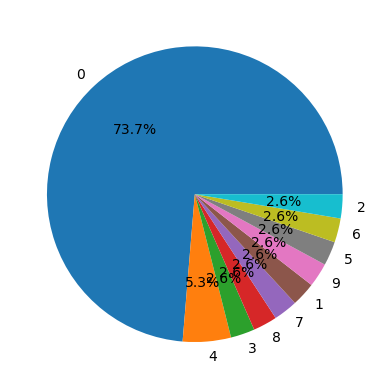

In [85]:
# визуализация распределения кластеров Kmeans
cluster_counts = dfHabr1['clustersKmeans'].value_counts()
plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%')
plt.show()

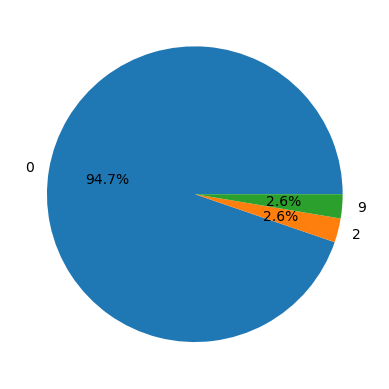

In [86]:
# визуализация распределения кластеров Spectral
cluster_counts = dfHabr1['clustersSpectral'].value_counts()
plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%')
plt.show()

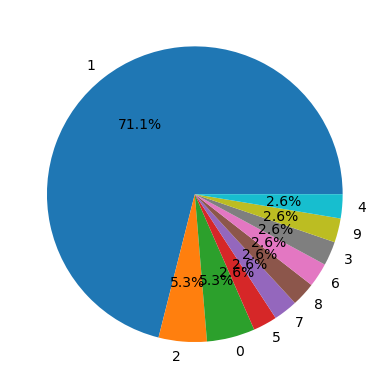

In [87]:
# визуализация распределения кластеров Agglomerative
cluster_counts = dfHabr1['clustersAgglomerative'].value_counts()
plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%')
plt.show()

#### Оценка качества кластеризации

In [88]:
a = (dfHabr1['clustersKmeans'] - dfHabr1['clustersKmeans'].mean()) / dfHabr1['clustersKmeans'].std()
a1 = (dfHabr1['clustersAgglomerative'] - dfHabr1['clustersAgglomerative'].mean()) / dfHabr1['clustersAgglomerative'].std()
a2 = (dfHabr1['clustersSpectral'] - dfHabr1['clustersSpectral'].mean()) / dfHabr1['clustersSpectral'].std()

In [89]:
data_norm_kmeans = a.values.reshape(-1, 1)
data_norm_agg = a1.values.reshape(-1, 1)
data_norm_spec = a2.values.reshape(-1, 1)

In [90]:
# оценка качества кластеризации с помощью индекса силуэта
silhouette_avg = silhouette_score(data_norm_kmeans, km.labels_)
print("Silhouette  score:", silhouette_avg)

Silhouette  score: 0.7894736842105263


In [91]:
# оценка качества кластеризации с помощью индекса силуэта
silhouette_avg = silhouette_score(data_norm_agg, agg.labels_)
print("Silhouette  score:", silhouette_avg)

Silhouette  score: 0.8157894736842105


In [92]:
# оценка качества кластеризации с помощью индекса силуэта
silhouette_avg = silhouette_score(data_norm_spec, spectral.labels_)
print("Silhouette  score:", silhouette_avg)

Silhouette  score: 0.9473684210526315


### 2.2 Тематическое моделирование

LDA - это метод машинного обучения, который используется для анализа тематической структуры в больших наборах документов. Который использует модель вероятности, чтобы определить, какие темы присутствуют в каждом документе, и какие слова связаны с каждой темой. LDA может быть полезен в случаях, когда нужно опредлить тематическую структуру в большом наборе документов, таких как статьи и т.д. 

In [93]:
# создание модели LDA
lda_model = LatentDirichletAllocation(n_components=10, random_state=0)
lda_model.fit(count_matrix)

# вывод топ слов для каждой темы
for i, topic in enumerate(lda_model.components_):
    print(f"Topic {i}: {', '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: рассказывать, июнь, мск, июнь мск, нетология, эксперт, нетология рассказывать, навык, руководитель, приглашать
Topic 1: цифровой, бизнес, год, работа, компания, профессия, аналитик, специалист, интернет, продукт
Topic 2: курс, аналитик, год, новый, нетология, программа, иннотеха, компания, обучение, команда
Topic 3: человек, язык, компьютерный, текст, лингвистика, речь, естественный, естественный язык, обработка, компьютерный лингвистика
Topic 4: команда, разработка, рассказывать, начинать, разработчик, год, митап, пост, московский, офис
Topic 5: разработка, рассказывать, программа, нетология, программирование, мобильный, интенсив, компонент, сергей, хотеть
Topic 6: пользователь, продукт, интерфейс, работа, весь, делать, задача, дизайнер, решение, сервис
Topic 7: кандидат, задача, координатор, команда, ответ, вопрос, сбермаркет, разработчик, экран, работа
Topic 8: работа, задача, проект, весь, команда, разработка, время, год, нетология, процесс
Topic 9: проблема, сервис, работ

In [94]:
print(str(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 0, 'keyword']))

12    кандидат, человек, команда, давать, например, ...
20    тест, юнит, код, проверять, функция, метод, об...
Name: keyword, dtype: object


In [95]:
len(lda_model.components_)

10

In [96]:
lda_model.components_

array([[0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       ...,
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 1.1, 1.1, 1.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]])

In [97]:
# создание матрицы документ-термин
tfidf_vectorizer = TfidfVectorizer(stop_words=russian_stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform(dfHabr2)

In [98]:
type(tfidf_matrix)

scipy.sparse._csr.csr_matrix

In [99]:
tfidf_matrix.shape

(38, 4312)

NMF - это метод машинного обучения, который используется для разложения матрицы на две с неотрицательными элементами. Он может быть полезен в случаях, когда нужно найти скрытые признаки в данных, таких как тексты и т.д. NMF может использоваться в различных областях, таких как обработка изображений, текстовый анализ и т.д

In [100]:
# создание модели NMF
nmf_model = NMF(n_components=10, random_state=0)
nmf_model.fit(tfidf_matrix)

# вывод топ слов для каждой темы
for i, topic in enumerate(nmf_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: кандидат, задача, собеседование, команда, человек, ответ, метрика, мочь, проект, процесс
Topic 1: курс, системный, аналитик, июнь, визуализация, нетология, студент, слушатель, интерактивный, занятие
Topic 2: поездка, год, сервис, корпорация, клиент, решение, нью, йорк, доклад, успешный
Topic 3: сбермаркет, митап, доклад, разработчик, трансляция, компонент, рассказывать, ссылка, написать, мобильный
Topic 4: инцидент, мониторинг, проблема, сервис, работать, поддержка, ответственный, работа, операционный, команда
Topic 5: нетология, программирование, регистрация, дверь, программа, участник, курсы, обучение, трансляция, вход
Topic 6: интенсив, лекция, мобильный, начинать, занятие, разработка, хотеть, профессия, кодер, специализация
Topic 7: цифровой, бизнес, образование, год, магистратура, программа, продукт, компьютерный, компания, интернет
Topic 8: координатор, экран, метод, юнит, тест, зависимость, объект, код, протокол, навигация
Topic 9: конференция, управление, доклад, коман

In [101]:
len(nmf_model.components_)

10

In [102]:
nmf_model.components_

array([[0.        , 0.        , 0.        , ..., 0.00987685, 0.01850549,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00236319,
        0.        ],
       [0.01058611, 0.        , 0.00140087, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.02022943, 0.00041363, ..., 0.0026861 , 0.00449285,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.04179918],
       [0.00090207, 0.        , 0.00100491, ..., 0.00013083, 0.00337441,
        0.        ]])

LSA - это метод машинного обучения, который используется для анализа структуры в больших наборах текстовых данных. Он использует матричные вычисления для определения близости между словами и документами. LSA может быть полезен в случаях, когда вы хотите определить структуру в большом наборе текстовых данных, таких как статьи, отчеты и т.д.

In [103]:
# создание модели LSA
lsa_model = TruncatedSVD(n_components=10, random_state=0)
lsa_model.fit(tfidf_matrix)

# вывод топ слов для каждой темы
for i, topic in enumerate(lsa_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: курс, команда, работа, задача, год, нетология, сервис, работать, аналитик, весь
Topic 1: курс, нетология, программа, аналитик, обучение, июнь, занятие, преподаватель, интенсив, системный
Topic 2: поездка, корпорация, курс, сервис, год, клиент, нью, йорк, успешный, расход
Topic 3: инцидент, курс, мониторинг, проблема, поддержка, ответственный, работать, операционный, пользователь, сервис
Topic 4: курс, инцидент, сбермаркет, мониторинг, трансляция, проблема, компонент, приложение, мобильный, сервис
Topic 5: нетология, программирование, дверь, регистрация, инцидент, открытый, трансляция, факультет, курсы, вход
Topic 6: интенсив, мобильный, лекция, начинать, занятие, профессия, приложение, разработка, кодер, специализация
Topic 7: координатор, цифровой, бизнес, образование, метод, экран, юнит, тест, магистратура, июнь
Topic 8: конференция, доклад, аналитик, управление, рассказывать, бизнес, поделиться, вопрос, ошибка, тема
Topic 9: конференция, интенсив, координатор, лекция, анали

In [104]:
len(lsa_model.components_)

10

In [105]:
lsa_model.components_

array([[ 0.00639109,  0.00263867,  0.00327199, ...,  0.00227182,
         0.0056096 ,  0.00273477],
       [-0.00447218,  0.0020011 , -0.00238475, ..., -0.00112572,
         0.00318261, -0.00286701],
       [ 0.00562793,  0.00093015, -0.00102961, ..., -0.00282971,
        -0.00674303, -0.00940638],
       ...,
       [-0.00491742,  0.01026289,  0.00121962, ..., -0.00092106,
         0.00238061,  0.01597398],
       [ 0.01092589,  0.00158861,  0.02104197, ..., -0.00036278,
         0.00763253, -0.01747941],
       [-0.00489038, -0.00454893, -0.00061936, ..., -0.00203834,
        -0.0055932 ,  0.01418657]])

В итоге лучшей моделью является LDA, т.к. она в данном случае самая нужная, и работает лучше всего (определяет тематическую структуру в большом наборе документов, таких как статьи и т.д.)

#### Визуализация тематического моделирования

In [106]:
pyLDAvis.enable_notebook()

In [107]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 0, 'keyword'])

12    кандидат, человек, команда, давать, например, ...
20    тест, юнит, код, проверять, функция, метод, об...
Name: keyword, dtype: object


In [108]:
# визуализация модели LDA
panel = pyLDAvis.sklearn.prepare(lda_model, count_matrix, vectorizer, mds='tsne', sort_topics=False)
panel

C:\Users\essww\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      -83.255753   62.709824       1        1   1.465806
1      124.020386   -7.982010       2        1  23.520847
2       78.277977   77.459793       3        1   3.062378
3       -5.685704   49.550766       4        1  10.940002
4      -32.508926  -99.427116       5        1   0.944171
5      -23.194555  -23.035299       6        1   2.216526
6       55.428082  -81.832932       7        1   7.532437
7     -100.710083  -24.152020       8        1  16.940371
8       48.534454   -1.907685       9        1  24.306369
9       -2.710744  125.507248      10        1   9.071094, topic_info=               Term       Freq      Total Category  logprob  loglift
12772  компьютерный  31.000000  31.000000  Default  30.0000  30.0000
11187      кандидат  46.000000  46.000000  Default  29.0000  29.0000
36750         текст  28.000000  28.000000  Default  28.0000  28.0000
30117  рассказывать  40.000000  40.000000  Default  27.0000  27.0000
41733          язык  62.000000  62.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
37409   технический   5.892850  22.849863  Topic10  -6.9052   1.0449
24084      понимать   5.892850  39.844222  Topic10  -6.9052   0.4888
15912          мочь   5.892851  64.387855  Topic10  -6.9052   0.0089
28229       процесс   5.892850  69.663386  Topic10  -6.9052  -0.0699
40785       человек   5.892850  76.852662  Topic10  -6.9052  -0.1681

[698 rows x 6 columns], token_table=       Topic      Freq                   Term
term                                         
185        4  0.825378  адаптивный технология
340        2  0.101967               алгоритм
340        4  0.509835               алгоритм
340        7  0.203934               алгоритм
340        8  0.101967               алгоритм
...      ...       ...                    ...
41733      4  0.481796                   язык
41733      6  0.016060                   язык
41733      7  0.032120                   язык
41733      8  0.128479                   язык
41733      9  0.112419                   язык

[1304 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [109]:
# визуализация модели NMF
panel = pyLDAvis.sklearn.prepare(nmf_model, tfidf_matrix, tfidf_vectorizer, mds='tsne', sort_topics=False)
panel

C:\Users\essww\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\essww\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\Users\essww\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0       5.166951  16.197231       1        1  18.426892
1      49.651146 -35.393990       2        1   8.058286
2       1.095391  55.572826       3        1  10.227265
3      41.180706  41.168468       4        1  11.035489
4     -35.096199  32.995243       5        1   9.031219
5       9.204204 -18.881002       6        1   6.769228
6      13.540073 -58.202820       7        1   6.651898
7     -26.638636 -43.571392       8        1  15.143243
8     -32.429012  -5.469147       9        1   7.209920
9      46.567200   3.035027      10        1   7.446560, topic_info=             Term      Freq     Total Category  logprob  loglift
1435         курс  2.000000  2.000000  Default  30.0000  30.0000
1123     интенсив  1.000000  1.000000  Default  29.0000  29.0000
1925    нетология  1.000000  1.000000  Default  28.0000  28.0000
1362  координатор  0.000000  0.000000  Default  27.0000  27.0000
2487      поездка  0.000000  0.000000  Default  26.0000  26.0000
...           ...       ...       ...      ...      ...      ...
402        вопрос  0.188856  0.872062  Topic10  -5.1675   1.0675
3971      условие  0.145615  0.278816  Topic10  -5.4275   1.9478
2998     работать  0.172006  1.252751  Topic10  -5.2610   0.6118
2150         опыт  0.153409  0.678463  Topic10  -5.3754   1.1107
1302     компания  0.156492  1.215672  Topic10  -5.3555   0.5474

[743 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
80        2  0.653013          аналитик
179       8  0.879130            бизнес
578       3  0.707002               год
578       8  0.707002               год
754       4  0.777545            доклад
906       1  0.708964            задача
1123      7  0.849206          интенсив
1150      5  1.378804          инцидент
1214      1  0.989070          кандидат
1355     10  1.186914       конференция
1362      9  1.143725       координатор
1435      2  0.839871              курс
1461      7  1.187179            лекция
1603      9  1.753696             метод
1640      4  1.323507             митап
1658      7  0.991080         мобильный
1674      5  1.229769        мониторинг
1806      7  1.128771          начинать
1925      6  0.529922         нетология
2024      8  1.447324       образование
2487      3  1.049212           поездка
2817      5  1.039564          проблема
2844      6  1.020623  программирование
3127      6  1.405255       регистрация
3259      4  0.785824        сбермаркет
3326      3  0.787263            сервис
3364      2  1.237430         системный
4168      8  1.073643          цифровой
4262      9  1.899830             экран, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

К сожалению, модель LSA через pyLDAvis невозможно вывести

In [110]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 0, 'keyword'])

12    кандидат, человек, команда, давать, например, ...
20    тест, юнит, код, проверять, функция, метод, об...
Name: keyword, dtype: object


#### Распределение кластеров по тематическому моделированию

In [111]:
# Массив, в котором будут сохраняться перебранные lda компоненты
topics = []

for i, topic in enumerate(lda_model.components_):
    # топ векторизованных слов
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
    topic_string = f"Topic {i}: {', '.join(top_words)}"
    # добавление
    topics.append(topic_string)

In [112]:
dfCosinTest = pd.DataFrame({'texts': topics})

In [113]:
dfj = {'texts': [], 'cos_similarities' : [], 'cluster': []}

In [114]:
# цикл, который реализует сравнение топ слов lda модели и кластеров, для правильного подбора кластера к lda модели
for i in range(0, 10):
    # выбор текста - цели
    find_nearest_to = str(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == i, 'keyword'])
    # формирование весов tf-idf
    tfidf = TfidfVectorizer()
    mx_tf = tfidf.fit_transform(topics)
    new_entry = tfidf.transform([find_nearest_to])
    sdf = pd.DataFrame.sparse.from_spmatrix(mx_tf)
    new_entry = tfidf.transform([find_nearest_to])
    pd.DataFrame.sparse.from_spmatrix(new_entry)
    # создание косинуснового сходства
    cosine_similarities = cosine_similarity(new_entry, mx_tf).flatten()
    dfCosinTest['cos_similarities'] = cosine_similarities
    # сортировка, для выбора наибольшего сходства
    dfCosinTest = dfCosinTest.sort_values(by=['cos_similarities'], ascending=[0])
    dfCosinTest = dfCosinTest.reset_index(drop=True)
    dfj['texts'].append(dfCosinTest['texts'][0])
    dfj['cos_similarities'].append(dfCosinTest['cos_similarities'][0])
    dfj['cluster'].append(i)

In [115]:
dfClusters = pd.DataFrame(data = dfj)

In [116]:
dfClusters.head(15)

,texts,cos_similarities,cluster
0,"Topic 7: кандидат, задача, координатор, команд...",0.309516,0
1,"Topic 8: работа, задача, проект, весь, команда...",0.553005,1
2,"Topic 2: курс, аналитик, год, новый, нетология...",0.649826,2
3,"Topic 8: работа, задача, проект, весь, команда...",0.496361,3
4,"Topic 2: курс, аналитик, год, новый, нетология...",0.716878,4
5,"Topic 0: рассказывать, июнь, мск, июнь мск, не...",0.668540,5
6,"Topic 7: кандидат, задача, координатор, команд...",0.671748,6
7,"Topic 8: работа, задача, проект, весь, команда...",0.444262,7
8,"Topic 7: кандидат, задача, координатор, команд...",0.526470,8
9,"Topic 2: курс, аналитик, год, новый, нетология...",0.606202,9


### 2.4 Разведочный анализ

C:\Users\essww\AppData\Local\Temp\ipykernel_12192\785557542.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dfHabr1['clustersAgglomerative'], shade=True)


<module 'matplotlib.pyplot' from 'C:\\Users\\essww\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

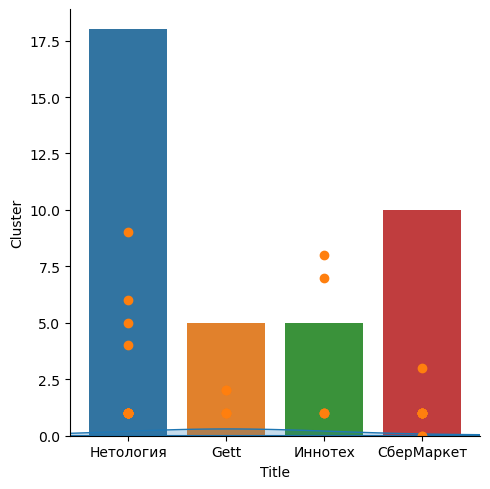

In [117]:
sns.catplot(x='TitleCompany', kind='count', data=dfHabr1)
# анализ плотности распределения целевой переменной
sns.kdeplot(dfHabr1['clustersAgglomerative'], shade=True)
# визуализация зависимости кластеров от временных признаков
plt.scatter(dfHabr1['TitleCompany'], dfHabr1['clustersAgglomerative'])
plt.xlabel('Title')
plt.ylabel('Cluster')
plt 

In [118]:
# сохраняем DataFrame в файл
dfHabr1.to_csv(r'Downloads\Report2.csv', index=False, encoding='utf-8')

### 2.5 Подготовка отчета




__2.1 Поиск ключевых слов/n-грамм. Векторизация текста__ Пункт был выполнен без нареканий. Биграммы, триграммы и векторизация выполнены успешно.

__2.2 Тематическое моделирование__ Сначала была выполнена кластеризация, потом тематическое моделирование. Само тематическое моделирование было выполнено тремя способами LDA, NMF и LSA, оно прошло успешно и была выбрана LDA.

    __2.2.1 LDA__ (лучшая модель) выбрал потому, что он может быть полезен в случаях, когда нужно опредлить тематическую структуру в большом наборе документов, таких как статьи и т.д. 

    __2.2.2 NMF__ выбрал потому, что он может быть полезен в случаях, когда нужно найти скрытые признаки в данных, таких как тексты и т.д.

    __2.2.3 LSA__ выбрал потому, что он может быть полезен в случаях, когда нужно определить структуру в большом наборе текстовых данных, таких как статьи, отчеты и т.д.


__2.3 Кластеризация__ Предварительная обработка данных выполнена без проблем. Кластеры показали себя одинакого, по сравнению друг с другом из-за того, что текста довольно разные и их мало, оценка кластеризации не сработало из-за маленького количества строк, в соответствии кластеров.

    __2.3.1 Agglomerative__ выбрал потому, что он полезен в случаях, когда нужно разбить данные на группы на основе их сходства.

    __2.3.2 Kmeans__ выбрал потому, что он полезен в случаях, когда нужно разбить данные на группы на основе их сходства.

    __2.3.3 Spectral__ выбрал потому, что он полезен в случаях, когда нужно разбить данные на группы на основе их сходства, но данные не могут быть разделены на группы в исходном пространстве признаков.

__2.4 Разведочный анализ__ Предварительная обработка данных выполнена полностью, без проблем.

### Вывод

В итоге датафрейм почти полностью готов к 3-ей Сессии. Но есть небольшие недочеты, по типу того, что датасет очень маленький. И проблемы связанные с этим. Такие как проблема с кластеризацией.

